In [1]:
from LSTM_BigBirdA2C_GumbelSoftmax import *
from dataset import make_data_generator
import json
from tqdm import tqdm_notebook as tqdm
#from torchsummary import summary

In [2]:
folder = '/tmp2/Food/'
data_name = folder+'data.json'
# validation_name = folder+'valid_seq.json'
# testdata_name = folder+'testdata_seq.json'
vocab_name = folder+'vocab.json'

In [3]:
num_epochs = 10
save_rate = 1 #how many epochs per modelsave
#continue_from = "trained/Model1" # if none, put None
continue_from = None
epsilon = 1e-8
validation_size = 10000
device = torch.device('cuda')
!mkdir -p trained

In [4]:
vocab = json.load(open(vocab_name, 'r'))
VOC_SIZE = len(vocab)
INPUT_MAX = 100
SUMM_MAX = 20
UNK = "[UNK]"
BOS = "[CLS]"
EOS = "[SEP]"
PAD = "[PAD]"

In [5]:
batch_size = 32

training_set, training_generator = make_data_generator(\
data_name, INPUT_MAX, SUMM_MAX, vocab[PAD], batch_size, cutoff=None, shuffle=True, num_workers=4)

# validation_set, validation_generator = make_data_generator(\
# validation_name, INPUT_MAX, OUTPUT_MAX, vocab[PAD], batch_size, cutoff=validation_size, shuffle=False, num_workers=4)

def data_gen_train():
    for src, label, tgt in training_generator:
        src = src.to(device)
        label = (label).long().to(device)
        tgt = tgt.to(device)
        b = Batch(src, tgt, vocab[PAD])
        b.label = label
        yield b

loading json
load json done.


In [6]:
import math
total_train = int(math.ceil(training_set.size / batch_size))
# total_valid = int(math.ceil(validation_set.size / batch_size))
# print(total_train, total_valid)

In [7]:
def init_param(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

def make_big_bird(vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1, emb_share=False, bert_share=False):
    "Helper: Construct a model from hyperparameters."
    
    vocab_sz = len(vocab)
    
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    src_emb = nn.Sequential(Embeddings(d_model, vocab_sz), c(position))
    if emb_share:        
        tgt_emb = src_emb
        bert_class_emb = src_emb
        bert_discr_emb = src_emb
    else:
        tgt_emb = nn.Sequential(Embeddings(d_model, vocab_sz), c(position))
        bert_class_emb = nn.Sequential(Embeddings(d_model, vocab_sz), c(position))
        bert_discr_emb = nn.Sequential(Embeddings(d_model, vocab_sz), c(position))
    
    
    bert_class = BERT(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        bert_class_emb,
        vocab[PAD]
    )
    
    if bert_share:
        bert_discr = bert_class
    else:
        bert_discr = BERT(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            bert_discr_emb,
            vocab[PAD]
        )
        
    translator = LSTM_Gumbel_Encoder_Decoder(
        hidden_dim=d_model, 
        emb_dim=d_model, 
        input_len=INPUT_MAX, 
        output_len=SUMM_MAX, 
        voc_size=vocab_sz, 
        critic_net=CriticNet(2*d_model),
        device=device,
        eps=1e-8
    )
    
    reconstructor = LSTM_Normal_Encoder_Decoder(
        hidden_dim=d_model, 
        emb_dim=d_model, 
        input_len=SUMM_MAX, 
        output_len=INPUT_MAX, 
        voc_size=vocab_sz, 
        pad_index=vocab[PAD],
        eps=1e-8
    )
#     translator = Translator(
#         Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
#         Decoder(DecoderLayer(d_model, c(attn), c(attn), 
#                              c(ff), dropout), N),
#         src_emb,
#         tgt_emb,
#         Generator(d_model, vocab_sz, device),
#         CriticNet(d_model)
#         )
    
#     classifier = Classifier(
#         bert_class,
#         out_class = 5
#         # criterion = BCE
#     )
#     reconstructor = Reconstructor(
#         Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
#         Decoder(DecoderLayer(d_model, c(attn), c(attn), 
#                              c(ff), dropout), N),
#         src_emb,
#         tgt_emb,
#         Generator(d_model, vocab_sz, device),
#         vocab[PAD]
#     )   
    discriminator = Discriminator(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        d_model,
        len(vocab),
        vocab[PAD]
    )


    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for m in [translator, reconstructor, discriminator]:
        init_param(m)
        
#     if(str(device) == 'cpu'):
#         savedmodel = torch.load("pretrained/Translator4", map_location=lambda storage, location: storage)
#     else:
#         savedmodel = torch.load("pretrained/Translator4")
#     translator.load_state_dict(savedmodel['model'], strict=False)
#     if(str(device) == 'cpu'):
#         savedmodel = torch.load("pretrained/Translator4", map_location=lambda storage, location: storage)
#     else:
#         savedmodel = torch.load("pretrained/Translator4")
#     reconstructor.load_state_dict(savedmodel['model'])#, strict=False)
            
    # creation of big bird
    model = BigBird(
        translator, discriminator, reconstructor , 
        vocab, gamma=0.99, clip_value=0.1, #for WGAN, useless if WGAN-GP is used 
        lr_G = 5e-5,
        lr_D = 1e-4,
        lr_R = 2e-5,
        LAMBDA = 10, # Gradient penalty lambda hyperparameter
        RL_scale = 1,
        device = device
    )

    return model


In [8]:
model = make_big_bird(vocab, N=4, d_model=128, d_ff=256, h=4, dropout=0.1, emb_share=True, bert_share=True)
model.load("Nest/NewbornBirdA2C_LSTM_GumbelSoftmax")

load Bird from Nest/NewbornBirdA2C_LSTM_GumbelSoftmax


In [9]:
vocab_inv = {a:b for b, a in vocab.items()}
def convert_ids_to_tokens(ids):
    return [vocab_inv[i] for i in ids]

In [10]:
start = 1 if continue_from == None else (int(continue_from.split("Model")[-1])+1)
history = []


#from tensorboardX import SummaryWriter
#writer = SummaryWriter('mygraph')
writer = None
all_loss = []
all_reward = []

for epoch in range(start, num_epochs+1):
    print("Epoch", epoch)
    
    # training
    stats = Stats()
    model.train()
    
    rewards = []
    
    trange = tqdm(enumerate(data_gen_train()), total=total_train)
    for i, batch in trange:
        loss, score  = model.run_iter(batch.src, batch.src_mask, SUMM_MAX, batch.trg, writer, D_iters=5, verbose = 1)
        trange.set_postfix(
            **{'RL_loss': '{:.3f}'.format(loss[0])},
            **{'G_loss': '{:.3f}'.format(loss[1])},
            **{'D_loss': '{:.3f}'.format(loss[2])},
            **{'real_score': '{:.3f}'.format(score[0])},
            **{'fake_score': '{:.3f}'.format(score[1])},
            **{'acc': '{:.3f}'.format(score[2])},
            **{'reward':'{:.3f}'.format(score[3])}
        )
        stats.update(sum(loss), 1, log=0)
        rewards.append(score[3])
        
    t_h = stats.history
    history.append(t_h)
    #writer.add_scalar('reward', np.mean(t_h), epoch)
    print("[info] epoch train loss:", np.mean(t_h))
    print("[info] epoch train reward:", sum(rewards)/len(rewards))
    all_loss.append(np.mean(t_h))
    all_reward.append(sum(rewards)/len(rewards))
#writer.close()  
#     try:
#         torch.save({'model':model.state_dict(), 'training_history':t_h, 'validation_loss':np.mean(v_h)}, 
#                    "trained/Model"+str(epoch))
#     except:
#         continue

Epoch 1


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
origin:
['[CLS]', 'this', 'tastes', 'great', '.', 'i', 'love', 'peanut', 'butter', ',', 'but', 'not', 'all', 'the', 'fat', '.', 'i', 'mix', 'this', 'with', 'my', 'protein', 'shake', 'and', 'it', 'tastes', 'great', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
summary:
['[CLS]', '[CLS]', 'stuff', 'stuff', '[CLS]', 'stuff'

lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
origin:
['[CLS]', 'lara', '##bar', '##s', 'are', 'delicious', ',', 'and', 'i', 'was', 'amazed', 'when', 'i', 'read', 'the', 'ingredients', 'list', '.', 'there', "'", 's', 'nothing', 'but', 'real', ',', 'healthy', 'things', '!', 'i', "'", 've', 'only', 'had', 'the', 'apple', 'pie', 'flavor', ',', 'which', 'i', 'was', 'told', 'was', 'the', 'best', ',', 'and', 'it', 'was', 'really', 'great', '.', 'i', 'can', 'have', 'a', 'sweet', 'treat', 'during', 'the', 'day', ',', 'i', 'just', 'have', 'to', 'snack', ',', 'but', 'it', "'", 's', 'healthy', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
summary:
['[CLS]', 'stuff', 'stuff', 'stuff', '[SEP]', '[SEP]', '[SEP]', '[

lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
origin:
['[CLS]', 'i', 'just', 'bought', 'these', 'for', 'the', 'first', 'time', '.', 'wow', '!', 'they', 'are', 'wonderful', '-', '-', 'not', 'at', 'all', 'something', 'that', 'simulate', '##s', 'pre', '##tze', '##l', 'taste', '.', 'many', 'times', 'the', 'g', '##lu', '##ten', 'free', 'products', 'i', 'try', 'are', 'not', 'even', 'a', 'good', 'imitation', 'of', 'the', 'real', 'thing', '.', 'this', 'is', 'not', 'the', 'case', 'with', 'these', 'pre', '##tze', '##ls', '.', 'i', 'took', 'them', 'to', 'my', 'office', 'and', 'let', 'everyone', 'try', 'them', '.', 'i', 'had', 'a', 'hard', 'time', 'keeping', 'everyone', 'away', 'after', 'one', 'taste', '!', '<', 'br', '/', '>', '<', 'br', '/', '>', 'one', 'serious', 'word', 'of', 'caution', '-', '-']
summary:
['[CLS]', 'stuff', 'stuff', 'stuff', '[SEP]', '[SEP]', '[SEP]', '[SEP]', '[SEP]', '[SEP]', '[SE

lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
origin:
['[CLS]', 'just', 'want', 'to', 'share', 'that', 'the', 'pamela', 'baking', '&', 'pan', '##cake', 'mix', 'is', 'the', 'best', 'i', "'", 've', 'tried', 'so', 'far', '.', 'when', 'following', 'the', 'directions', ',', 'the', 'batter', 'is', 'a', 'little', 'too', 'watery', ',', 'so', 'i', 'add', 'just', 'a', 'little', 'bit', 'more', 'mix', 'and', 'vo', '##ila', ',', 'great', 'pancakes', '.', 'my', 'husband', '(', 'who', 'is', 'not', 'g', '##lu', '##ten', 'free', ')', 'likes', 'them', 'too', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
summary:
['[CLS]', 'stuff', '[SEP]', '[SEP]', '[SEP]', 

lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
origin:
['[CLS]', 'i', 'purchased', 'a', 'two', 'pack', 'of', 'this', 'rose', 'pet', '##al', 'black', 'tea', 'because', 'it', 'was', 'a', 'more', 'affordable', 'option', '.', 'it', 'is', 'so', 'nice', 'to', 'know', 'that', 'once', 'we', 'finish', 'the', 'first', 'tin', 'we', "'", 've', 'got', 'a', 'second', 'one', 'in', 'the', 'cupboard', ':', ')', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
summary:
['[CLS]', '[

lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
origin:
['[CLS]', 'just', 'plain', 'nasty', '!', '!', '!', 'this', 'item', 'tasted', 'like', 'cardboard', ',', 'very', 'watered', 'down', 'and', 'no', 'flavor', 'to', 'it', 'at', 'all', '.', 'very', 'disappointed', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
origin:
['[CLS]', 'i', 'have', 'been', 'using', 'kc', '##ups', 'for', 'a', 'few', 'years', 'now', 'and', 'recently', 'discovered', 'these', '.', 'i', 'was', 'sc', '##ept', '##ical', 'but', 'decided', 'to', 'try', 'the', 'sf', 'bay', 'french', 'roast', ',', 'fog', 'chase', '##r', 'and', 'rainforest', 'blend', '##s', '.', 'i', 'generally', 'like', 'strong', ',', 'dark', 'blend', '##s', 'like', 'em', '##eri', '##ls', 'or', 'dark', 'magic', '.', 'overall', ',', 'all', '3', 'of', 'the', 'sf', 'bay', 'blend', '##s', 'are', 'really', 'good', '.', 'the', 'french', 'roast', 'is', 'my', 'favorite', 'though', '.', 'it', 'is', 'strong', 'and', 'has', 'a', 'rich', 'flavor', 'and', 'is', 'not', 'bitter', '.', 'the', 'fog', 'chase', '##r', 'is', 'strong', 'and', 'a', 'bit']
summary:
['[CLS]', '[SEP]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
origin:
['[CLS]', 'stanley', 'cooper', '##smith', '(', 'clint', 'howard', ')', 'is', 'a', 'lonely', 'and', 'misunderstood', 'ne', '##rd', 'at', 'a', 'military', 'school', 'and', 'is', 'constantly', 'picked', 'on', 'everyday', 'by', 'the', 'local', 'bull', '##ies', '.', 'one', 'day', 'he', 'is', 'searching', 'down', 'in', 'the', 'cellar', 'of', 'the', 'chapel', 'and', 'discovers', 'some', 'ancient', 'material', 'on', 'dark', 'magic', 'and', 'uses', 'a', 'personal', 'computer', 'for', 'the', 'powers', 'of', 'evil', ',', 'he', 'will', 'soon', 'get', 'his', 'revenge', 'with', 'the', 'powers', 'of', 'hell', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'entertaining', 'and', 'go', '##ry', 'sci', '-', 'fi', 'horror', 'thriller', 'that', 'plays', 'as', 'a', 'cross', 'between', '"', 'war', 'games']
summary:
['[CLS]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', 

lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
origin:
['[CLS]', 'this', 'stuff', 'is', 'just', 'plain', "'", 'ole', 'yu', '##mmy', '!', 'i', 'would', 'have', 'preferred', 'not', 'to', 'have', 'to', 'order', '12', 'of', 'them', '.', '.', '.', 'but', 'i', 'am', 'unable', 'to', 'find', 'this', 'in', 'any', 'store', 'around', 'here', 'and', 'the', 'ex', '##piration', 'date', 'is', 'almost', 'a', 'year', 'and', 'a', 'half', 'away', '.', '.', '.', 'good', 'luck', 'making', 'it', 'last', 'anywhere', 'near', 'that', 'long', 'around', 'here', '!', '!', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
summary:
['[CLS]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

origin:
['[CLS]', 'this', 'is', 'the', 'second', 'pacific', 'health', 'brand', 'i', 'have', 'used', ',', 'the', 'first', 'being', 'the', 'orange', 'flavor', '##ed', 'acc', '##ele', '##rade', '.', 'i', 'tried', 'this', 'one', 'because', 'it', 'has', 'less', 'sugar', '.', 'it', 'also', 'has', 'less', 'protein', ',', 'which', 'i', 'didn', '##t', 'know', 'until', 'i', 'got', 'it', ',', 'my', 'bad', 'for', 'not', 'checking', 'ahead', 'of', 'time', '.', 'the', 'product', 'taste', 'fine', ',', 'but', 'it', 'did', 'not', 'come', 'with', 'a', 'scoop', ',', 'which', 'i', 'found', 'odd', ',', 'especially', 'since', 'the', 'directions', 'state', 'that', 'one', 'serving', 'size', 'is', 'one', 'scoop', '.', 'maybe', 'i', 'just', 'got', 'the', 'one', 'can', 'that', 'didn', '##t']
summary:
['[CLS]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
real summary:
['[CLS]', 'no', 'sco

lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
origin:
['[CLS]', 'i', 'have', 'to', 'say', 'that', 'i', 'find', 'this', 'particular', 'bottle', 'disappointing', '.', 'i', 'have', 'purchased', 'this', 'item', 'before', 'in', 'new', 'orleans', 'and', 'the', 'flavor', 'was', 'better', 'than', 'the', 'recent', 'bottle', 'i', 'have', 'received', '.', 'i', 'won', "'", 't', 'purchase', 'again', 'on', '-', 'line', 'but', 'will', 'wait', 'to', 'find', 'it', 'in', 'stores', '.', 'even', 'the', 'color', 'of', 'the', 'hot', 'sauce', 'was', 'more', 'orange', 'than', 'usual', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
summary:
['[CLS]', '[SEP]

lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
origin:
['[CLS]', 'the', 'cookies', 'were', 'kind', 'of', 'st', '##ail', 'but', 'other', 'than', 'that', 'it', 'was', 'fast', 'shipping', 'and', 'good', 'packing', 'the', 'cookies', 'weren', "'", 't', 'broken', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
summary:
['[CLS]', '[SEP]', '[PAD]', '[PAD]

lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
origin:
['[CLS]', 'this', 'is', 'a', 'very', 'delicious', 'tea', 'with', 'the', 'wonderful', 'benefit', 'of', 'yer', '##ba', 'mate', '.', 'like', 'other', 'posters', ',', 'i', 'really', 'don', "'", 't', 'enjoy', 'the', 'taste', 'of', 'the', 'plain', 'yer', '##ba', 'mate', 'and', 'usually', 'blend', 'it', 'with', 'a', 'spicy', 'tea', '.', 'this', 'is', 'the', 'only', 'tea', 'that', 'can', 'compete', 'with', 'my', 'love', 'of', 'a', 'great', 'rich', 'cup', 'of', 'coffee', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
summary:
['[CLS]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
origin:
['[CLS]', 'i', 'bought', 'this', 'at', 'my', 'local', '"', 'sp', '##rou', '##ts', '"', 'supermarket', 'this', 'week', ',', 'not', 'based', 'on', 'the', 'various', 'negative', 'reviews', 'of', 'the', 'product', 'on', 'here', '.', 'i', 'almost', 'passed', 'on', 'it', 'but', 'basin', '##g', 'my', 'purchase', 'on', 'the', 'nutrition', 'facts', ',', 'i', 'decided', 'to', 'take', 'a', 'chance', '.', 'i', 'paid', '$', '35', 'plus', 'tax', 'for', 'it', '.', '<', 'br', '/', '>', 'i', 'plan', 'to', 'use', 'this', 'as', 'part', 'of', 'a', 'lunch', 'time', 'meal', 'replacement', '.', '<', 'br', '/', '>', 'each', 'serving', 'contains', ':', '<', 'br', '/', '>', '90', 'cal', '##ories', '<', 'br', '/', '>', '9', 'g', 'car']
summary:
['[CLS]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
real summary

lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax
origin:
['[CLS]', 'i', 'discovered', 'that', 'this', 'particular', 'flavor', 'wakes', 'me', 'right', 'up', 'for', 'the', 'long', 'drive', 'home', 'after', 'dark', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C_LSTM_GumbelSoftmax


KeyboardInterrupt: 

In [11]:
import matplotlib.pyplot as plt

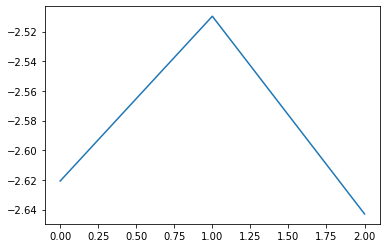

In [12]:
plt.plot(range(len(all_loss)), all_loss)
plt.show()

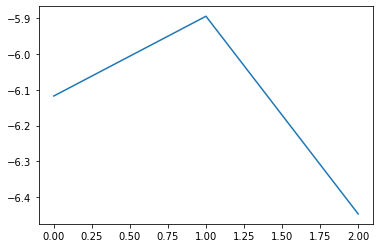

In [13]:
plt.plot(range(len(all_reward)), all_reward)
plt.show()

In [ ]:
#print(model.all_rewards)
#plt.plot(range(len(model.all_rewards)), model.all_rewards)

In [ ]:
#plt.plot(range(len(model.all_rewards)-1), [sum(model.all_rewards[:i])/i for i in range(1,len(model.all_rewards))])